In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import io
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
from IPython.display import clear_output
from numpy.typing import NDArray
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

In [3]:
from qml.model.gate import get_gateset, Gate, GateInfo
from qml.model.unit import Unit, EmbedUnit, EntangleUnit
from qml.model.model import Model
from qml.tools.trainer import calc_gradients
from qml.tools.dataloader import DataLoader

In [83]:
%matplotlib inline
np.set_printoptions(precision=3, floatmode='fixed')

In [5]:
# settings
nq = 2
nx = 1
ng = 3
gateset = get_gateset(nq)

## Prepare dataset

In [9]:
target_func = lambda x: np.sin(np.pi * x)

In [10]:
train_xs = np.random.uniform(-1, 1, 20)
train_ys = target_func(train_xs)

test_xs = np.random.uniform(-1, 1, 20)
test_ys = target_func(test_xs)

## Build model

In [12]:
emb_unit = EmbedUnit.generate_ry_arcsin_embed_unit("emb", nq, nx, gateset=gateset)

In [7]:
tr1_units = [
    Unit.generate_random_unit(f"tr1_{i}", nq, ng, gateset=gateset)
    for i in range(6)
]
print(tr1_units)

[<qml.model.unit.Unit object at 0x115a57620>, <qml.model.unit.Unit object at 0x115a57170>, <qml.model.unit.Unit object at 0x115a7e660>, <qml.model.unit.Unit object at 0x115a7f1a0>, <qml.model.unit.Unit object at 0x115a7f380>, <qml.model.unit.Unit object at 0x115a7d730>]


In [11]:
ent_unit = EntangleUnit.new_neighbor_cz("en1", nq, gateset=gateset)

### Estimation func

In [49]:
models = [
    Model(nq, 1, emb_unit, [], [tr1_unit, ent_unit], shots=50)
    for tr1_unit in tr1_units
]

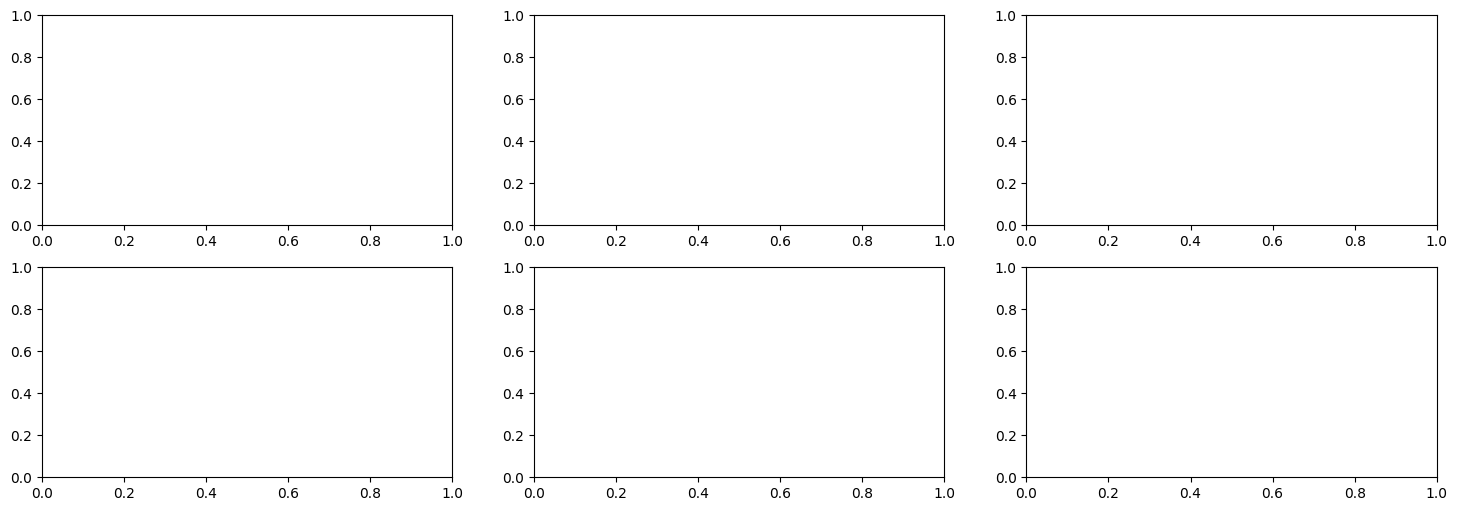

In [22]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18, 6))

In [43]:
def get_qc_image(model):
    buf = io.BytesIO()
    fig_ = model.draw()
    fig_.savefig(buf, format='png', dpi=180)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

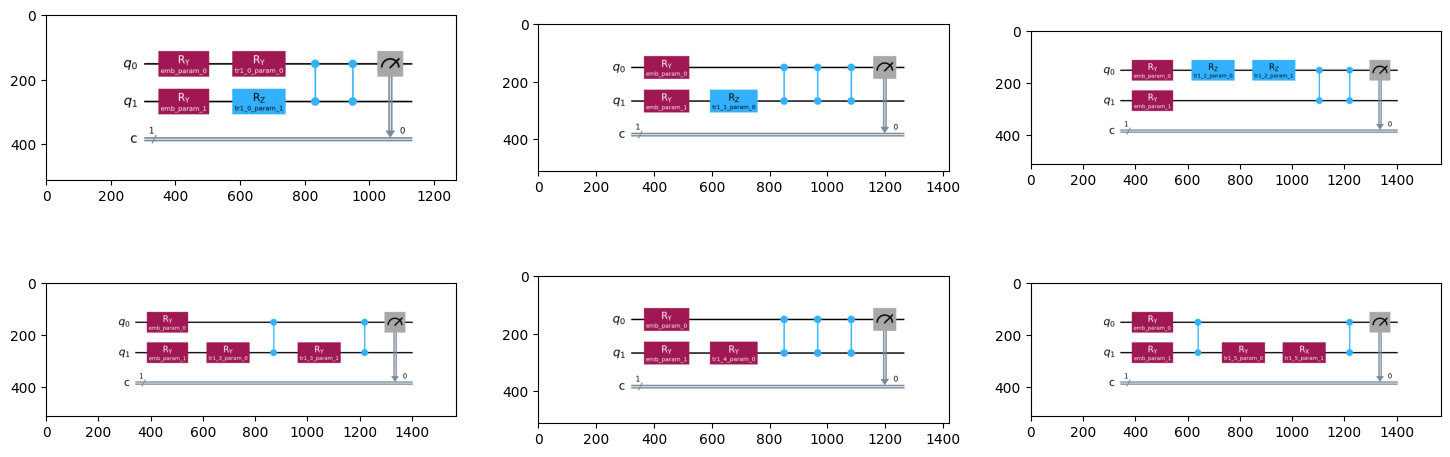

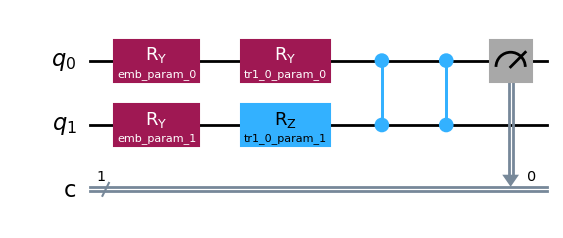

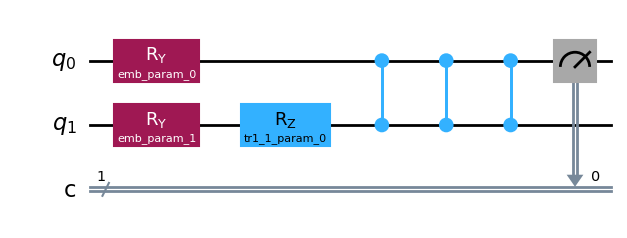

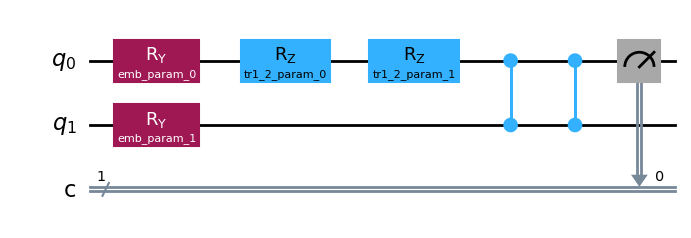

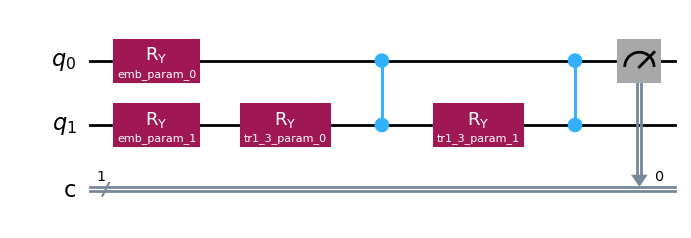

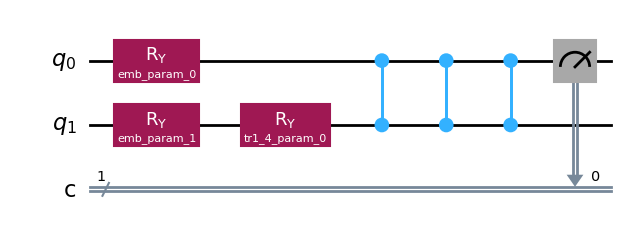

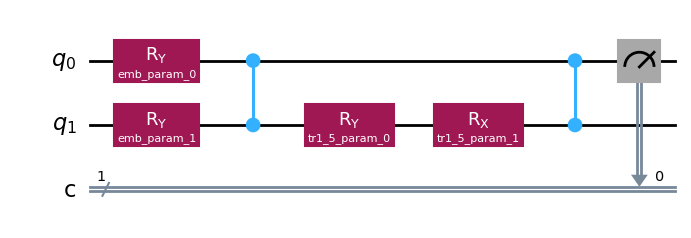

In [50]:
for ax, model in zip(axes.flatten(), models):
    img = get_qc_image(model)
    ax.imshow(img)
fig

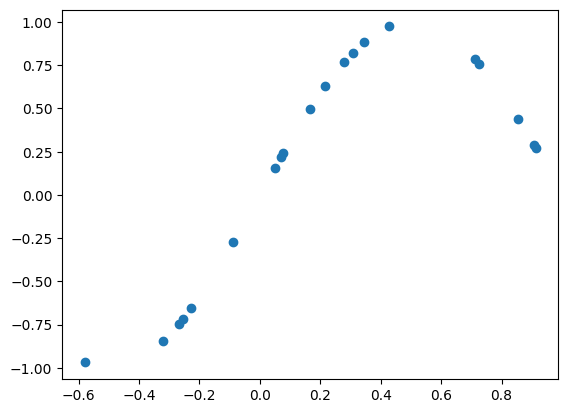

In [46]:
plt.scatter(train_xs, train_ys)

In [88]:
model = models[0]
params = model.trainable_parameters

class Evaluator:

    def __init__(self, xs, ys, model=None, shots=50):
        self._xs = xs
        self._ys = ys
        self._model = model
        self.shots = shots

    def __call__(self, params=None, model=None):
        if model is None:
            model = self._model
        return Evaluator.evaluate(
            model, params, self._xs, self._ys, shots=self.shots
        )

    @staticmethod
    def evaluate(model, params, xs, ys, shots=50):
        predicts = np.asarray([
            model.forward(x, params=params, shots=shots)
            for x in xs
        ])
        errors = ys - predicts
        loss = np.square(errors).mean()
        return loss

In [87]:
def propose_candidate(current):
    current = np.asarray(current)
    shift_val = np.random.normal(0, 0.1, size=current.shape)
    candidate = current + shift_val
    return candidate % (np.pi * 2)

## Local Search

In [170]:
model = models[0]

def train_model_lc(
        model, num_iter, train_data, test_data=None, shots=50, test_interval=5
):
    if test_data is None:
        test_data = train_data
    train_evaluator = Evaluator(*train_data, model=model, shots=shots)
    train_eval = lambda x: train_evaluator([x])
    test_evaluator = Evaluator(*test_data, model=model, shots=shots)
    test_eval = lambda x: test_evaluator([x])

    xc = model.trainable_parameters[0]
    ec = eval(xc)

    log_ep = []
    log_eb = []
    log_et = []
    log_step = []

    for i in range(num_iter):
        step = i + 1
        xp = propose_candidate(xc)
        ep = train_eval(xp)

        if ep <= ec:
            xc = xp
            ec = ep

        log_ep.append(ep)
        log_eb.append(ec)
        log_et.append(test_eval(xc))
        log_step.append(step)

        clear_output()
        print(f"{step:3d}| loss:{ep:6.3f}")
        fig, ax = plt.subplots()
        ax.plot(log_step, log_ep, label="proposed")
        ax.plot(log_step, log_eb, label="best")
        plt.show()

    result = pd.DataFrame(dict(
        step=log_step,
        energy=log_eb,
        candidate=log_ep,
        test=log_et,
    ))

    return xc, result

In [171]:
res = train_model_lc(model, 20, (train_xs, train_ys), (test_xs, test_ys), shots=50)
res

NameError: name 'self' is not defined

### Class for Search

In [100]:
Data = namedtuple("Data", ["xs", "ys"])

In [159]:
class Logger:

    def __init__(self):
        self._step_total = []
        self._step_test = []
        # variables
        self._variable_proposed = []
        self._variable_current = []
        self._variable_best = []
        self._variable_test = []
        # energies
        self._energy_proposed = []
        self._energy_current = []
        self._energy_best = []
        self._energy_test = []

    def store(self, step, xp, xc, xb, ep, ec, eb):
        self._step_total.append(step)
        self._variable_proposed.append(xp)
        self._variable_current.append(xc)
        self._variable_best.append(xb)
        self._energy_proposed.append(ep)
        self._energy_current.append(ec)
        self._energy_best.append(eb)

    def store_test(self, step, xt, et):
        self._step_test.append(step)
        self._variable_test.append(xt)
        self._energy_test.append(et)

    @property
    def result_energies(self):
        return pd.DataFrame(dict(
            step=self._step_total,
            proposed=self._energy_proposed,
            current=self._energy_current,
            best=self._energy_best,
        ))

    @property
    def result_variable(self):
        xb = np.vstack(self._variable_best)
        return pd.DataFrame(
            dict(step=self._step_total) | {
                i: xb[..., i]
                for i in range(xb.shape[1])
            }
        )

    @property
    def result_test(self):
        return pd.DataFrame(dict(
            step=self._step_test,
            energy=self._energy_test,
        ))

In [172]:
class LocalSearchOptimizer:

    MAX_THETA = np.pi * 2

    def __init__(
            self,
            train_data: Data,
            test_data: Data = None,
            shots: int = 100,
            test_interval: int = 5,
            variance: float = 0.1,
    ):
        self._train_data = train_data
        if test_data is None:
            test_data = train_data
        self._test_data = test_data
        self._shots = shots
        self._test_interval = test_interval
        self._variance = variance
        self._logger = None

    def prepare_evaluator(self, data, model, shots):
        evaluator = Evaluator(data.xs, data.ys, model=model, shots=shots)
        params = model.trainable_parameters
        nums_params = [len(param) for param in params]
        nums_params.insert(0, 0)
        def eval_func(x):
            xs = [
                x[idx_de:idx_to]
                for idx_de, idx_to in zip(nums_params[:-1], nums_params[1:])
            ]
            return evaluator(xs)
        return eval_func

    def optimize(
            self,
            model: Model,
            num_iter: int,
            shots: int = None,
            test_interval: int = None,
    ):
        train_eval = self.prepare_evaluator(self._train_data, model, shots=shots)
        test_eval  = self.prepare_evaluator(self._test_data,  model, shots=shots)

        xc = np.hstack(model.trainable_parameters)
        ec = train_eval(xc)

        xb = xc
        eb = ec

        logger = Logger()
        logger.store(0, xc, xc, xb, ec, ec, eb)
        logger.store_test(0, xc, test_eval(xc))

        for i in range(num_iter):
            step = i + 1
            xp = self.propose_candidate(xc)
            ep = train_eval(xp)

            if ep <= ec:
                xc = xp
                ec = ep
            if ep <= eb:
                xb = xp
                eb = ep

            logger.store(step, xp, xc, xb, ep, ec, eb)

            if step % self._test_interval == 0:
                logger.store_test(step, xc, test_eval(xc))

            clear_output()
            fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
            logger.result_energies.plot(x="step", y=["proposed", "current", "best"], ax=axes[0])
            logger.result_test.plot(x="step", y="energy", ax=axes[0])
            logger.result_variable.plot(x="step", ax=axes[1])
            plt.show()

        return logger

    def propose_candidate(self, xc):
        shift_val = np.random.normal(0, self._variance, size=xc.shape)
        print("shift_val:", shift_val)
        candidate = xc + shift_val
        return candidate % self.MAX_THETA



In [175]:
optimizer = LocalSearchOptimizer(
    Data(train_xs, train_ys),
    Data(test_xs, test_ys),
    shots=30,
    test_interval=5,
    variance=0.3
)

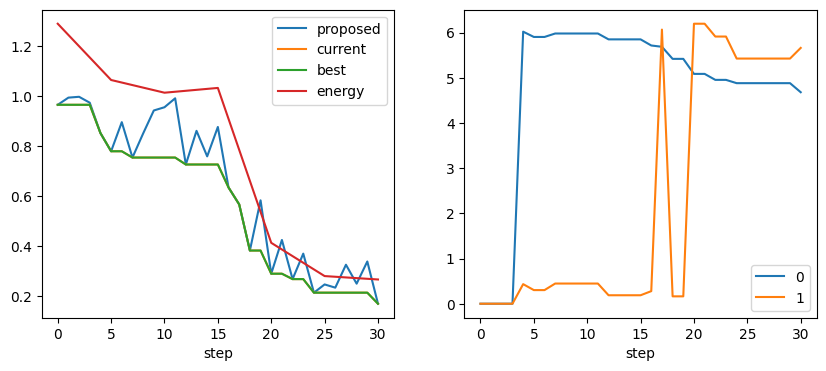

In [176]:
optimizer.optimize(model, 30)